## Leveraging High-Order Diffractions of Phase Hologram using Pupil Function for Enhanced Holographic Display
### 2023-06-19 
### Myeong-Ho Choi from Inha university
 

1. Load libraries

In [9]:
import torch
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

2. def some useful functions

In [215]:
def load_img_as_Tensor(file_location, resized_resolution=None, rgb2gray=None, device="cpu"):
    img = Image.open(file_location)

    tf_transforms = []

    if rgb2gray:
        tf_transforms.append(transforms.Grayscale())

    if resized_resolution is not None:
        tf_transforms.append(transforms.Resize(resized_resolution))

    tf_transforms.append(transforms.ToTensor())

    tf = transforms.Compose(tf_transforms)

    img_tensor = tf(img)

    # returns tensor of [Channel, Height, Width]
    return img_tensor.to(device)

def tensor2numpy(tensor):
    # input tensor should be normalized
    # Convert tensor to numpy array
    tmp = tensor.permute(1,2,0)

    np_array = tmp.cpu().detach().numpy()

    # Convert numpy array to PIL Image
    image = np.uint8(np_array * 255)

    # Return the PIL Image
    return image

def im2float(img, dtype=np.float32):
    """convert uint16 or uint8 image to float32, with range scaled to 0-1

    :param im: image
    :param dtype: default np.float32
    :return:
    """
    if issubclass(img.dtype.type, np.floating):
        return img.astype(dtype)
    elif issubclass(img.dtype.type, np.integer):
        return img / dtype(np.iinfo(img.dtype).max)
    else:
        raise ValueError(f'Unsupported data type {img.dtype}')
    
def mypupil(Nx, Ny, dx, dy, pupilRad, offsetX, offsetY, wvl, fl_EP, repnum):
    """ generate pupil function
    Nx:
    """
    dfx = 1 / (Nx * dx)
    dfy = 1 / (Ny * dy)

    minfx = -repnum * Nx / 2 * dfx
    maxfx = repnum * Nx / 2 * dfx
    minfy = -repnum * Ny / 2 * dfy
    maxfy = repnum * Ny / 2 * dfy

    fx = torch.linspace(minfx, maxfx, repnum * Nx)
    fy = torch.linspace(minfy, maxfy, repnum * Ny)

    flx = wvl * fl_EP * fx
    fly = wvl * fl_EP * fy

    flyfly, flxflx = torch.meshgrid(fly, flx)

    pupilMat = torch.zeros([repnum * Ny, repnum * Nx], dtype=torch.float32)
    pupilMat[(flxflx - offsetX) ** 2 + (flyfly - offsetY) ** 2 < (pupilRad) ** 2] = 1

    return pupilMat, flx, fly

def AS_propagation_torch(input, dx, dy, z, wavelength, device):

    if input.dim() == 2:
        input = input.unsqueeze(0)

    [Channel, Ny, Nx] = input.shape
    Nxx = 2 * Nx
    Nyy = 2 * Ny
    input2x = torch.zeros(Nyy, Nxx, dtype=input.dtype, device=device)
    start_x = round(Nx/2) - 1
    start_y = round(Ny/2) - 1
    output = torch.zeros_like(input)

    for i in range(Channel):
        if Channel == 1:
            wavelength = wavelength
        elif Channel == 3:
            wavelength = wavelength[i]

        k = 2 * torch.pi / wavelength
        tmp = input[i,:,:]
        input2x.narrow(0, start_y, Ny).narrow(1, start_x, Nx).copy_(tmp)
        dal = 1. / (Nxx * dx)  # delta alpha over lambda
        dbl = 1. / (Nyy * dy)  # delta beta over lambda

        bl, al = torch.meshgrid(torch.arange(Nyy, device=device), torch.arange(Nxx, device=device))
        al = (al - Nxx/2) * dal
        bl = (bl - Nyy/2) * dbl
        A = torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(input2x)))
        A = A.to(device)
        prop_kernel = torch.exp(1j * 2*torch.pi * z * torch.sqrt(1 / wavelength ** 2 - al ** 2 - bl ** 2))
        prop_kernel = prop_kernel.to(device)

        # K. Matsushima et al., "Band-limited angular spectrum method for numerical simulation of free-space propagation
        # in far and near fields," Opt. Express 17, 19662 (2009) 참조
        # FresnelPropagationShift_as.m 과 동일. 다만 sx=sy=0
        sx = 0
        sy = 0
        fla = torch.abs(-al * z / torch.sqrt(1 / wavelength ** 2 - al ** 2 - bl ** 2) + sx)
        flb = torch.abs(-bl * z / torch.sqrt(1 / wavelength ** 2 - al ** 2 - bl ** 2) + sy)
        prop_kernel[(fla > 1 / (2 * dal)) | (flb > 1 / (2 * dbl))] = 0

        intermediate = torch.fft.ifftshift(torch.fft.ifftn(torch.fft.fftshift(A * prop_kernel)))

        output_tmp = intermediate.narrow(0, start_y, Ny).narrow(1, start_x, Nx)
        output[i,:,:] = output_tmp
    du = dx
    dv = dy
    
    return output, du, dv



3. Pupil-considered CGH optimization code for single-channel image

In [384]:
# GPU assignment
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device: {}".format(device, torch.cuda.get_device_name(0)))

# hardware parameters
nm, um, mm, cm = np.array([1e-9, 1e-6, 1e-3, 1e-2])
px = np.array(3.74*um); py = px
Nx = 3840; Ny = 2160
fillfactor = 0.93
pa = fillfactor**0.5*px
wvl_laser = np.array([660, 520, 450]) * nm
z = -5*cm
fl_EP = 15*mm # eyepiece focal length
repnum = 5 # determines the number of high-order diffractions
iter = 1500
lr = 1e-1

# Load target image
img_dir = './sample_images/'
img_name = 'inhalogo.bmp'
img_tensor = load_img_as_Tensor(img_dir+img_name, rgb2gray=True, device=device)
# # ZeroPad2d(left, right, top, bottom)
m = nn.ZeroPad2d((200, 200, 200, 200))
img_tensor = m(img_tensor)
# plt.figure()
# plt.imshow(tensor2numpy(padimg))
imgChannel ,imgNy, imgNx = img_tensor.shape

# Set initial phase
# init_phase = (2*torch.pi*torch.rand([Ny,Nx], dtype=torch.float32)-torch.pi).to(device)
init_phase = (2*torch.pi*torch.rand([imgNy,imgNx], dtype=torch.float32)).to(device)
slm_phase = torch.clone(init_phase).to(device).requires_grad_(True)
s = torch.tensor(1.0, requires_grad=True, device=device)
optvars = [{'params':[slm_phase,s]}]
optimizer = torch.optim.Adam(optvars, lr=lr)
loss_fn = nn.MSELoss()

# SGD method
target_amp = img_tensor

x = []; y = []
print('Optimizing CGH using SGD withouth consideration of pupil function...')

for _ in range(iter):
    optimizer.zero_grad()
    wrapped_slm_phase = slm_phase % (2*torch.pi)
    slm_field = (1+torch.exp(1j*wrapped_slm_phase)).to(device) # assume uniform laser light is incident to SLM
    recon_field, dx, dy = AS_propagation_torch(slm_field, px, py, z, wvl_laser[1],device)
    recon_amp = recon_field.abs()
    loss = loss_fn(s*recon_amp, target_amp)
    loss.backward()
    optimizer.step()

    print("iteration: {}, loss: {}".format(_+1, loss))

    x.append(_)
    y.append(loss.cpu().detach().numpy())

del x, y
slm_phase_wo_pupil = wrapped_slm_phase


# preprocessing of target image
target_amp = transforms.Resize((repnum * imgNy, repnum * imgNx))(img_tensor)
rep_dfx = 1/(imgNx*px); rep_dfy = 1/(imgNy*py)
rep_minfx = -repnum/(2*px); rep_maxfx = repnum/(2*px)
rep_minfy = -repnum/(2*py); rep_maxfy = repnum/(2*py)
rep_fx = torch.linspace(rep_minfx, rep_maxfx, repnum*imgNx)
rep_fy = torch.linspace(rep_minfy, rep_maxfy, repnum*imgNy)
rep_fyfy, rep_fxfx = torch.meshgrid(rep_fy,rep_fx)
rep_fyfy = rep_fyfy.to(device); rep_fxfx = rep_fxfx.to(device)

# initialize slm_phase
slm_phase = torch.clone(init_phase).to(device).requires_grad_(True)
optvars = [{'params':[slm_phase,s]}]
optimizer = torch.optim.Adam(optvars, lr=lr)
# pupil_func, flx, fly = mypupil(imgNx,imgNy,px,py,2e-3,0,0,wvl_laser[1],fl_EP,repnum)
pupil_func, flx,fly = mypupil(imgNx, imgNy, px,py,3e-3,2.0e-3,2.0e-3,wvl_laser[1],fl_EP,repnum)
x = []; y = []
print('Optimizing CGH using SGD with consideration of pupil function...')
for _ in range(iter):
    optimizer.zero_grad()
    wrapped_slm_phase = slm_phase % (2*torch.pi)
    slm_field = (1+torch.exp(1j*wrapped_slm_phase)).to(device) # assume uniform laser light is incident to SLM
    fft_slm_field = torch.fft.ifftshift(torch.fft.fftn(torch.fft.fftshift(slm_field)))
    rep_fft_slm_field = fft_slm_field.repeat(repnum,repnum)*torch.sinc(pa*rep_fyfy)*torch.sinc(pa*rep_fxfx)
    filtered_fft_slm_field = pupil_func.to(device) * rep_fft_slm_field
    filtered_slm_field = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(filtered_fft_slm_field)))
    recon_field, dx, dy = AS_propagation_torch(filtered_slm_field, px/repnum, py/repnum, z, wvl_laser[1],device)
    recon_amp = recon_field.abs()
    loss = loss_fn(s*recon_amp, target_amp)
    loss.backward()
    optimizer.step()

    print("iteration: {}, loss: {}".format(_+1, loss))

    x.append(_)
    y.append(loss.cpu().detach().numpy())

slm_phase_w_pupil = wrapped_slm_phase



Using cuda device: NVIDIA GeForce RTX 4090
Optimizing CGH using SGD withouth consideration of pupil function...
iteration: 1, loss: 0.9827320575714111
iteration: 2, loss: 0.7055379152297974
iteration: 3, loss: 0.49719691276550293
iteration: 4, loss: 0.3468582332134247
iteration: 5, loss: 0.24341556429862976
iteration: 6, loss: 0.1764245182275772
iteration: 7, loss: 0.13666915893554688
iteration: 8, loss: 0.1164228618144989
iteration: 9, loss: 0.1094677522778511
iteration: 10, loss: 0.11095598340034485
iteration: 11, loss: 0.11719528585672379
iteration: 12, loss: 0.12542399764060974
iteration: 13, loss: 0.13361786305904388
iteration: 14, loss: 0.14034396409988403
iteration: 15, loss: 0.1446571946144104
iteration: 16, loss: 0.14602483808994293
iteration: 17, loss: 0.1442635953426361
iteration: 18, loss: 0.13947872817516327
iteration: 19, loss: 0.13200195133686066
iteration: 20, loss: 0.12233036011457443
iteration: 21, loss: 0.11106982082128525
iteration: 22, loss: 0.09888435155153275
ite

C:\Users\user\AppData\Local\Temp\ipykernel_4028\3851872544.py:26: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(filtered_fft_slm_field_conven.abs().cpu().detach().squeeze()))
C:\Users\user\AppData\Local\Temp\ipykernel_4028\3851872544.py:51: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(filtered_fft_slm_field_new.abs().cpu().detach().squeeze()))


Text(0.5, 1.0, 'filtered_recon_field_new')

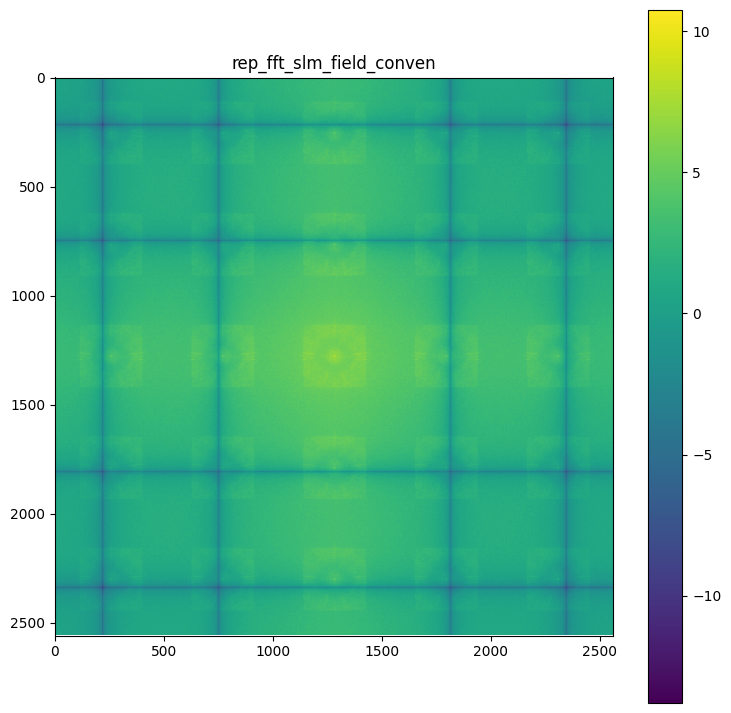

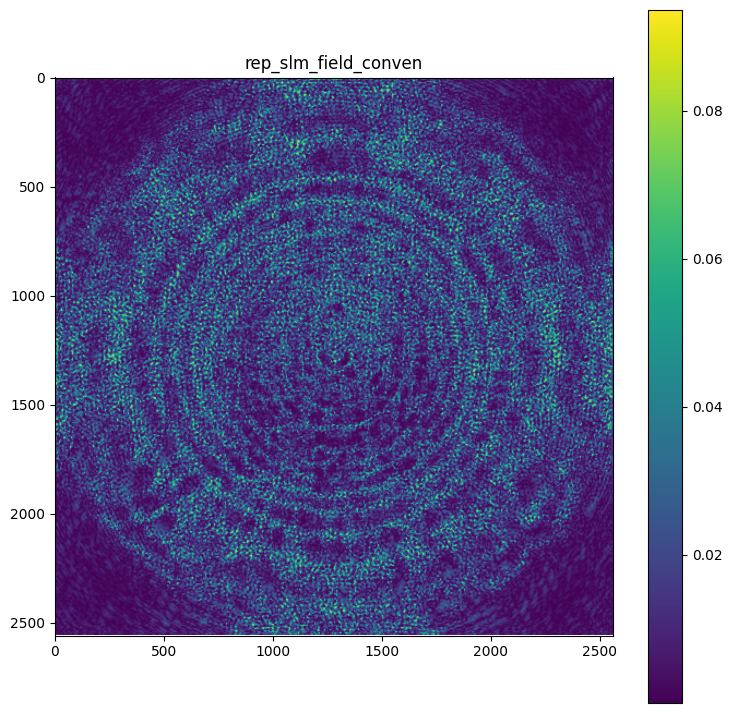

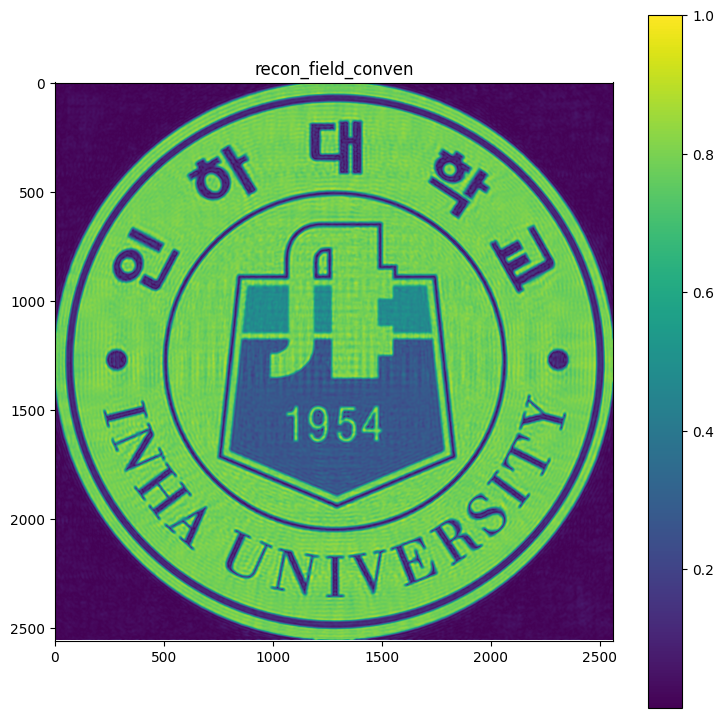

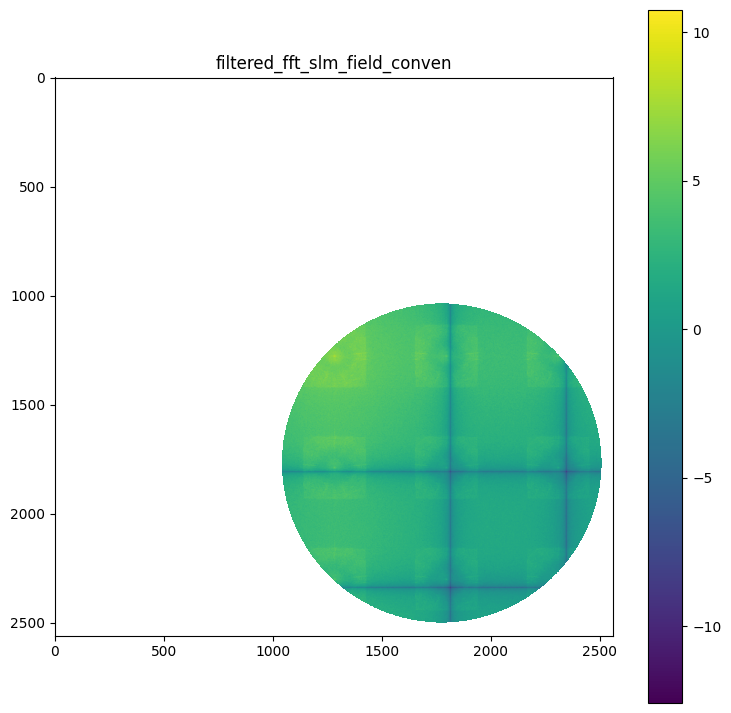

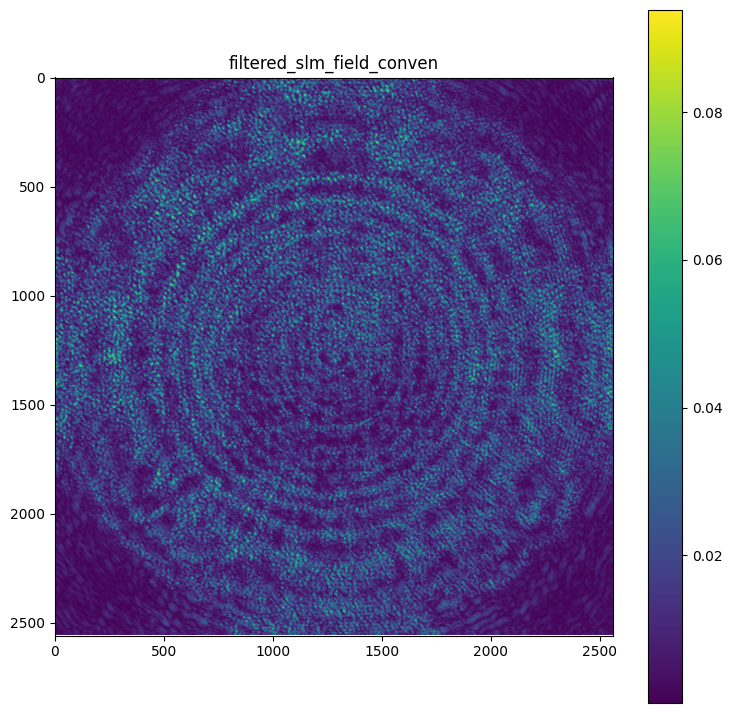

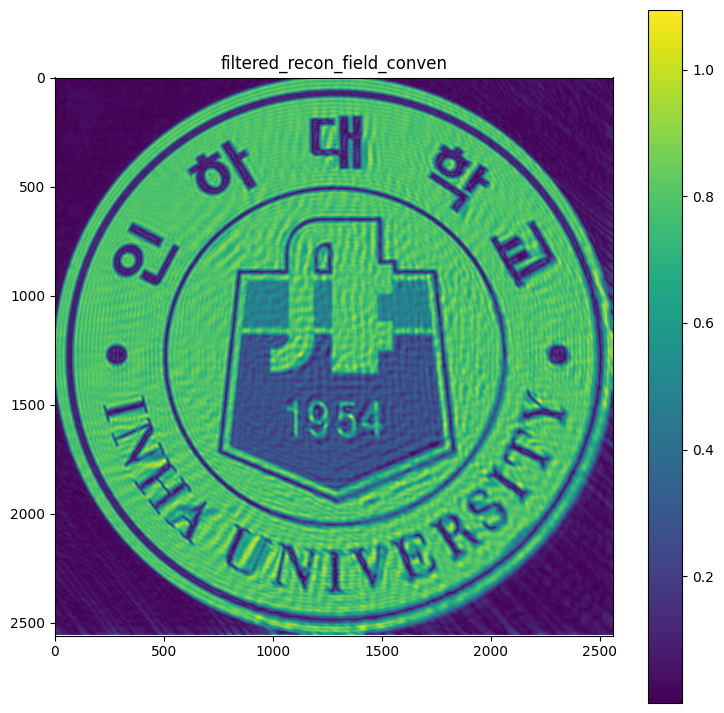

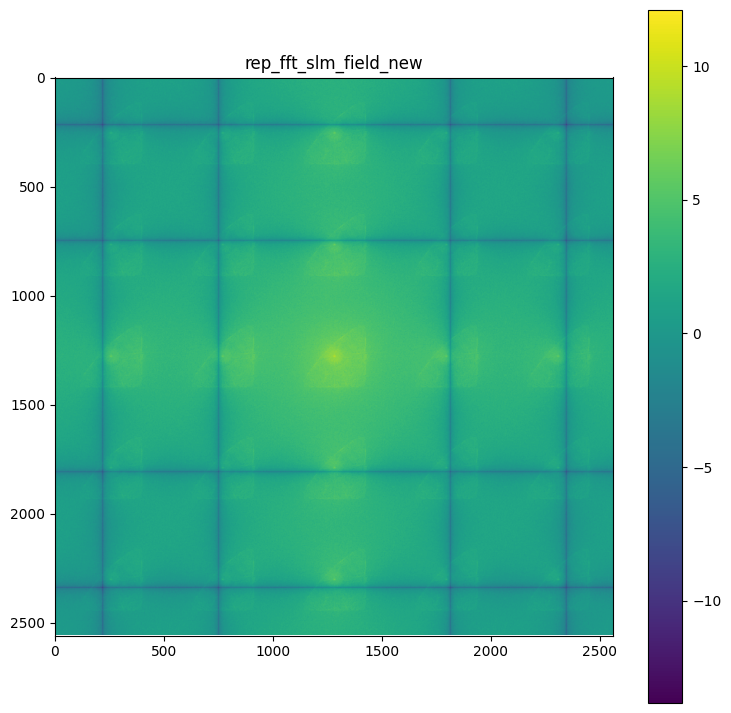

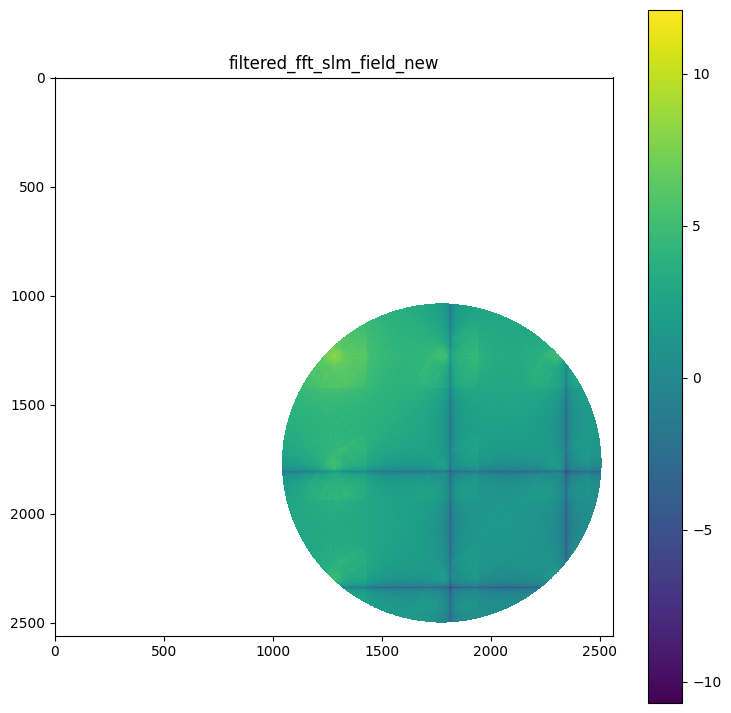

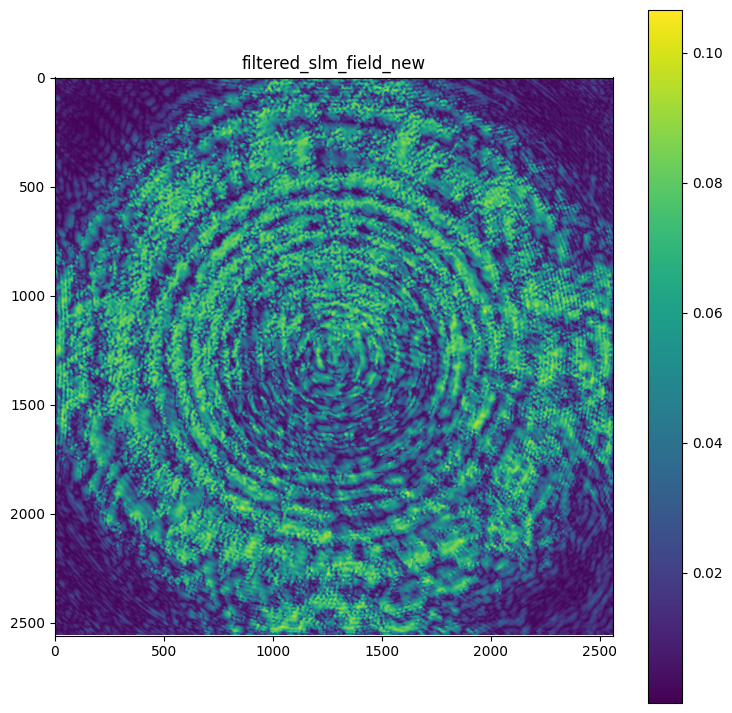

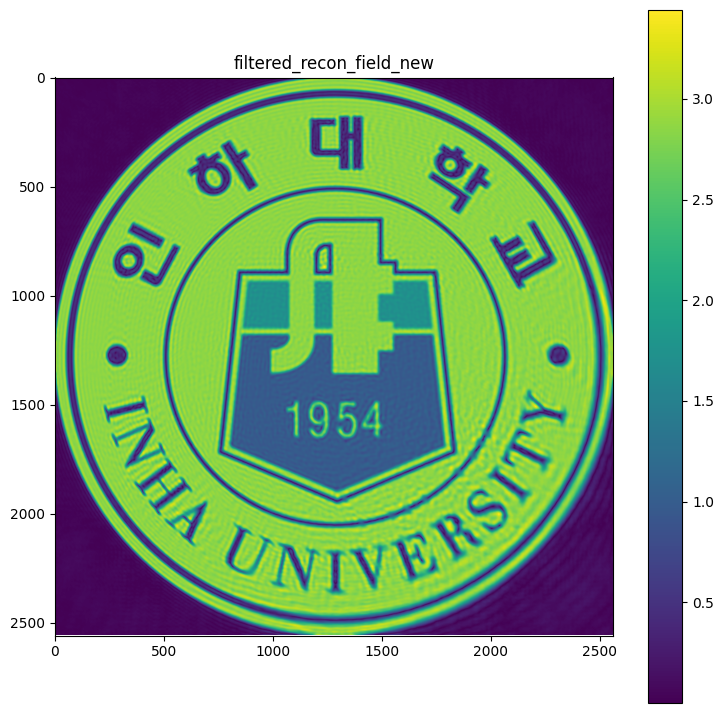

In [381]:
slm_field_conven = 1+torch.exp(1j*slm_phase_wo_pupil)
fft_slm_field_conven = torch.fft.ifftshift(torch.fft.fftn(torch.fft.fftshift(slm_field_conven)))
rep_fft_slm_field_conven = fft_slm_field_conven.repeat(repnum,repnum)*torch.sinc(pa*rep_fyfy)*torch.sinc(pa*rep_fxfx)
rep_slm_field_conven = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(rep_fft_slm_field_conven)))
recon_field_conven, dx, dy = AS_propagation_torch(rep_slm_field_conven,px/repnum,py/repnum,z,wvl_laser[1],device)
scale_factor = recon_field_conven.abs().cpu().detach().max()
plt.figure(figsize=(9,9))
plt.imshow(np.log(rep_fft_slm_field_conven.abs().cpu().detach().squeeze()))
plt.colorbar()
plt.title('rep_fft_slm_field_conven')
plt.figure(figsize=(9,9))
plt.imshow(rep_slm_field_conven.abs().cpu().detach().squeeze())
plt.colorbar()
plt.title('rep_slm_field_conven')
plt.figure(figsize=(9,9))
plt.imshow(recon_field_conven.abs().cpu().detach().squeeze()/scale_factor)
plt.colorbar()
plt.title('recon_field_conven')


filtered_fft_slm_field_conven = pupil_func.to(device) * rep_fft_slm_field_conven
filtered_slm_field_conven = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(filtered_fft_slm_field_conven)))
filtered_recon_field_conven, dx, dy = AS_propagation_torch(filtered_slm_field_conven,px/repnum,py/repnum,z,wvl_laser[1],device)

plt.figure(figsize=(9,9))
plt.imshow(np.log(filtered_fft_slm_field_conven.abs().cpu().detach().squeeze()))
plt.colorbar()
plt.title('filtered_fft_slm_field_conven')
plt.figure(figsize=(9,9))
plt.imshow(filtered_slm_field_conven.abs().cpu().detach().squeeze())
plt.colorbar()
plt.title('filtered_slm_field_conven')
plt.figure(figsize=(9,9))
plt.imshow(filtered_recon_field_conven.abs().cpu().detach().squeeze()/scale_factor)
plt.colorbar()
plt.title('filtered_recon_field_conven')


slm_field_new = 1+torch.exp(1j*slm_phase_w_pupil)
fft_slm_field_new = torch.fft.ifftshift(torch.fft.fftn(torch.fft.fftshift(slm_field_new)))
rep_fft_slm_field_new = fft_slm_field_new.repeat(repnum,repnum)*torch.sinc(pa*rep_fyfy)*torch.sinc(pa*rep_fxfx)
filtered_fft_slm_field_new = pupil_func.to(device) * rep_fft_slm_field_new
filtered_slm_field_new = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(filtered_fft_slm_field_new)))
filtered_recon_field_new, dx, dy = AS_propagation_torch(filtered_slm_field_new,px/repnum,py/repnum,z,wvl_laser[1],device)

plt.figure(figsize=(9,9))
plt.imshow(np.log(rep_fft_slm_field_new.abs().cpu().detach().squeeze()))
plt.colorbar()
plt.title('rep_fft_slm_field_new')
plt.figure(figsize=(9,9))
plt.imshow(np.log(filtered_fft_slm_field_new.abs().cpu().detach().squeeze()))
plt.colorbar()
plt.title('filtered_fft_slm_field_new')
plt.figure(figsize=(9,9))
plt.imshow(filtered_slm_field_new.abs().cpu().detach().squeeze())
plt.colorbar()
plt.title('filtered_slm_field_new')
plt.figure(figsize=(9,9))
plt.imshow(filtered_recon_field_new.abs().cpu().detach().squeeze()/scale_factor)
plt.colorbar()
plt.title('filtered_recon_field_new')

tensor(-10.4278)